# LSTM Forecasting of Earthquake Magnitude

In [1]:
# Prepare libraries
from data.data import EarthquakeData
from dotenv import load_dotenv
from earthquakes.settings import read_coordinates
from pathlib import Path
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [17]:
cwd = Path.home() / "earthquakes"
load_dotenv(cwd / ".env")

(minlat, maxlat), (minlong, maxlong) = read_coordinates()
qdata = EarthquakeData(
    pd.read_csv(Path.home() / "earthquakes/csv/9923ce9a42736848b544e335a4d7c5fb.csv"),
    numeric_columns=["latitude", "longitude", "depth", "mag"],
    zero_columns=["depth", "mag"],
    target="delta",
    time_column=True,
    delta_time=True,
    drop_time_column=True,
    min_latitude=minlat,
    min_longitude=minlong,
    # min_magnitude=2.5,
)
qdata.data

,latitude,longitude,depth,mag,delta
0,7.5430,-73.1080,162.000,4.9,0
1,7.2180,-77.7730,36.000,6.5,2035371
2,7.0690,-77.9170,33.000,5.0,4586
3,7.0860,-77.8900,33.000,4.5,561
4,6.8470,-72.9470,157.000,4.0,421577
...,...,...,...,...,...
4855,6.8307,-76.5252,50.621,4.3,1275947
4856,4.1915,-79.0146,10.000,4.5,67987
4857,2.5224,-79.0295,10.000,5.2,2573
4858,2.4816,-79.0522,10.000,4.7,11393


In [22]:
# from geopy.distance import geodesic

# df = qdata.data

# # Interaction features
# # df['lat_long'] = df['latitude'] + df['longitude']
# df['depth_mag'] = df['depth'] * df['mag']

# # Geospatial features
# # Example fixed point (latitude, longitude)
# fixed_point = (0, 0)
# df['distance_from_fixed'] = df.apply(lambda row: geodesic((row['latitude'], row['longitude']), fixed_point).km, axis=1)

# # Statistical features
# df['rolling_mean_depth'] = df['depth'].rolling(window=5).mean()
# df['rolling_std_depth'] = df['depth'].rolling(window=5).std()
# df['rolling_mean_mag'] = df['mag'].rolling(window=5).mean()
# df['rolling_std_mag'] = df['mag'].rolling(window=5).std()

# # Categorical features
# df['depth_category'] = pd.cut(df['depth'], bins=[0, 70, 300, np.inf], labels=['shallow', 'intermediate', 'deep'])
# df['mag_category'] = pd.cut(df['mag'], bins=[0, 4, 6, np.inf], labels=['low', 'moderate', 'high'])

# # Display the DataFrame with new features
# df.head()

,latitude,longitude,depth,mag,delta,lat_long,depth_mag,distance_from_fixed,rolling_mean_depth,rolling_std_depth,rolling_mean_mag,rolling_std_mag,depth_category,mag_category
0,7.543,-73.108,162.0,4.9,0,-65.565,793.8,8154.678380,NaN,NaN,NaN,NaN,intermediate,moderate
1,7.218,-77.773,36.0,6.5,2035371,-70.555,234.0,8668.255201,NaN,NaN,NaN,NaN,shallow,high
2,7.069,-77.917,33.0,5.0,4586,-70.848,165.0,8683.726111,NaN,NaN,NaN,NaN,shallow,moderate
3,7.086,-77.890,33.0,4.5,561,-70.804,148.5,8680.792591,NaN,NaN,NaN,NaN,shallow,moderate
4,6.847,-72.947,157.0,4.0,421577,-66.100,628.0,8134.023098,84.2,68.772814,4.98,0.936483,intermediate,low


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Assuming df is your DataFrame with the 'depth_category' column
df = qdata.data

# Encode the categorical features
label_encoder = LabelEncoder()
df['depth_category_encoded'] = label_encoder.fit_transform(df['depth_category'])

# Create sequences
sequence_length = 5
sequences = []
labels = []

for i in range(len(df) - sequence_length):
    sequences.append(df['depth_category_encoded'].iloc[i:i + sequence_length].values)
    labels.append(df['depth_category_encoded'].iloc[i + sequence_length])

sequences = np.array(sequences)
labels = np.array(labels)

# One-hot encode the labels
labels = to_categorical(labels)

# Split the data into training and testing sets
split = int(0.8 * len(sequences))
X_train, X_test = sequences[:split], sequences[split:]
y_train, y_test = labels[:split], labels[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Make predictions
predictions = model.predict(X_test)
predicted_categories = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Display the predictions
print(predicted_categories)

['latitude', 'longitude', 'depth', 'mag', 'delta']


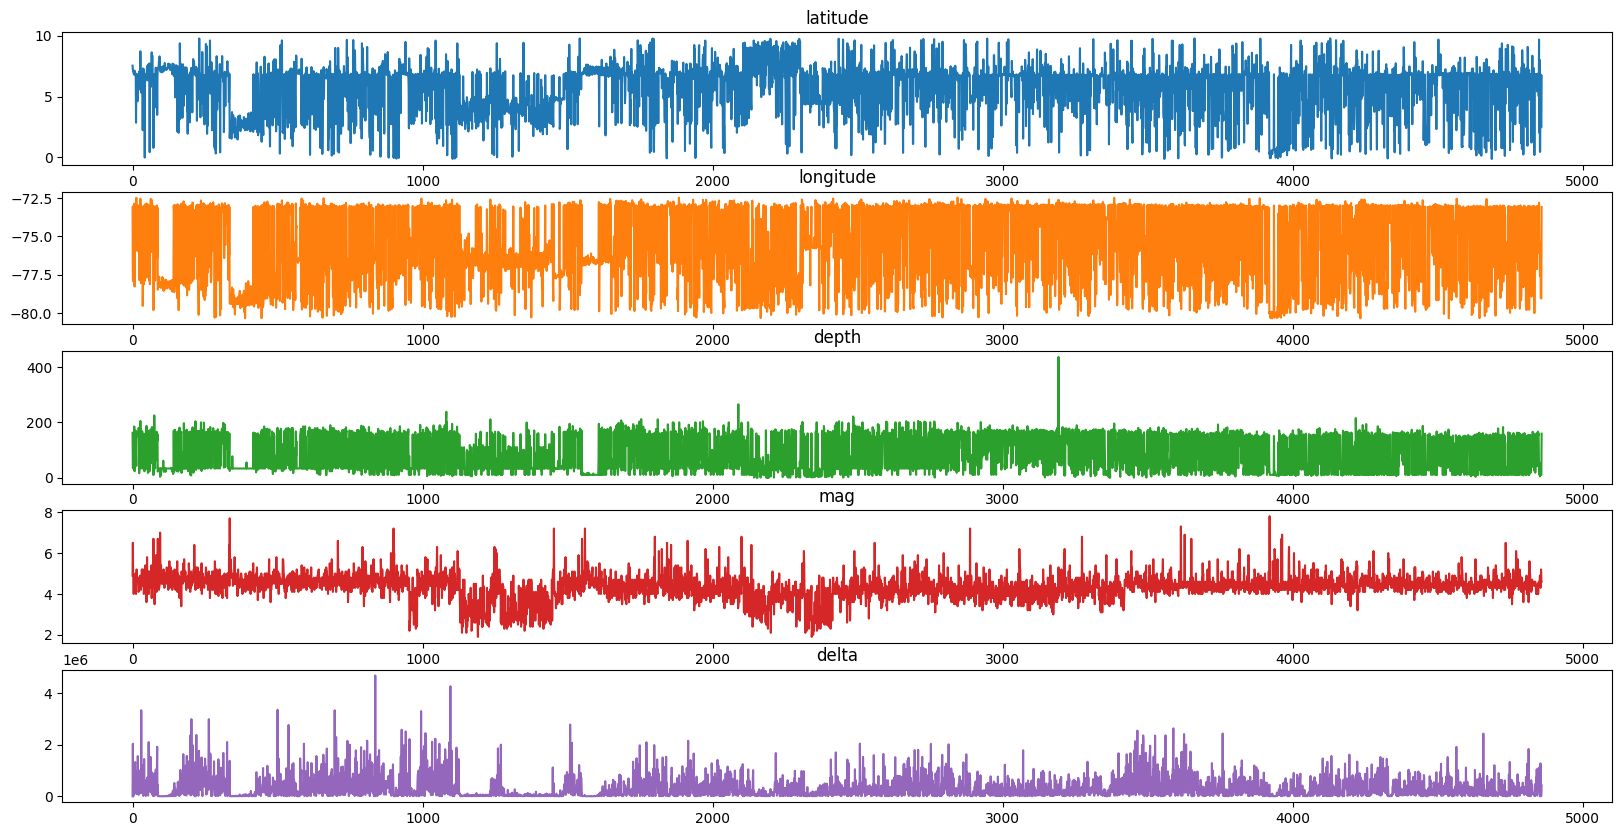

In [3]:
print(qdata.numeric_columns)

def get_color_from_palette(index, palette_name):
    """
    Returns a hex color string from a specified Matplotlib palette.

    Parameters:
    index (int): The index of the color in the palette.
    palette_name (str): The name of the Matplotlib palette.

    Returns:
    str: The hex color string.
    """
    # Get the palette colors
    colors = plt.get_cmap(palette_name).colors
    
    # Ensure the index is within the range of available colors
    if not 0 <= index < len(colors):
        raise ValueError("Index out of range for the specified palette.")
    
    # Convert the color to a hex string
    color = colors[index]
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255))
    
    return hex_color

timeseries = qdata.data[qdata.numeric_columns].astype('float32')
# timeseries["mag_delta"] = timeseries["mag"] * timeseries["delta"]
features = len(qdata.numeric_columns) 

def plot_timeseries(timeseries):
    """
    Plots the time series data.

    Parameters:
    timeseries (pd.DataFrame): The time series data.
    """
    # Create a figure and axis
    plots = len(timeseries.columns)
    fig, ax = plt.subplots(plots, 1, figsize=(20, 10))
    
    # Plot each time series
    for i in range(plots):
        ax[i].plot(timeseries.iloc[:, i], c=get_color_from_palette(i, 'tab10'))
        ax[i].set_title(timeseries.columns[i])
    
    plt.show()
    
def plot_histograms(timeseries):
    """
    Plots histograms of the time series data.

    Parameters:
    timeseries (pd.DataFrame): The time series data.
    """
    # Create a figure and axis
    plots = len(timeseries.columns)
    fig, ax = plt.subplots(plots, 1, figsize=(20, 10))
    
    # Plot histograms of each time series
    for i in range(plots):
        ax[i].hist(timeseries.iloc[:, i], bins=50, color=get_color_from_palette(i, 'tab10'), alpha=0.7)
        ax[i].set_title(timeseries.columns[i])
    
    plt.show()

plot_timeseries(timeseries)

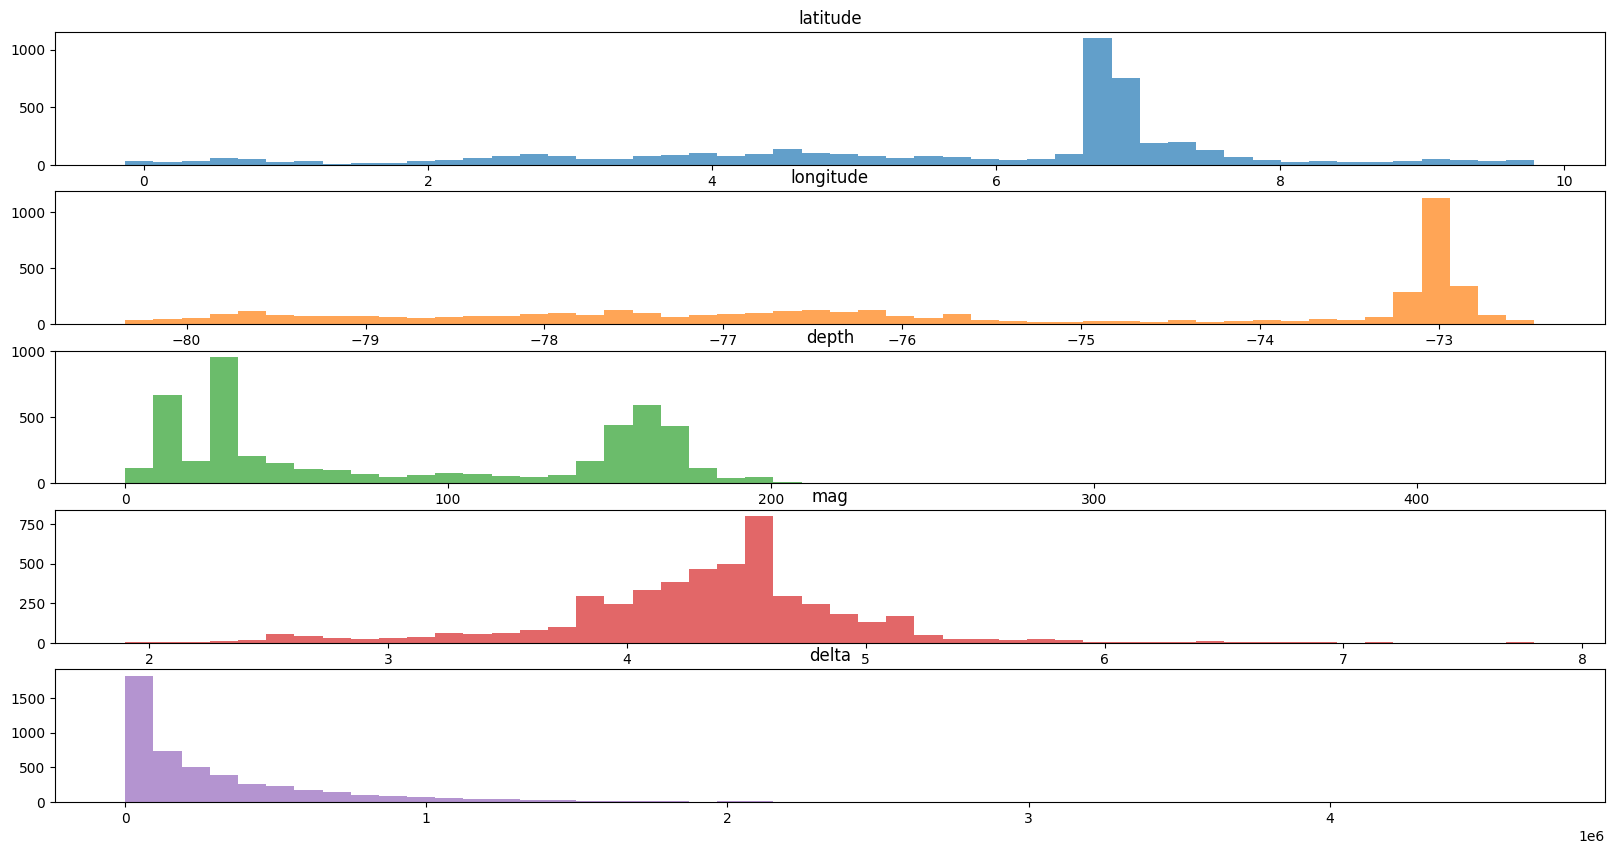

In [4]:
plot_histograms(timeseries)

In [5]:
features = len(qdata.numeric_columns)
batch_size = 10
hidden_size = 32
num_layers = 2
lookback = 50
(X_train, y_train), (X_val, y_val), (X_test, y_test) = qdata.train_test_split(lookback, 0.2, "minmax")
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([2886, 50, 5]) torch.Size([2886, 1])
torch.Size([962, 50, 5]) torch.Size([962, 1])
torch.Size([962, 50, 5]) torch.Size([962, 1])


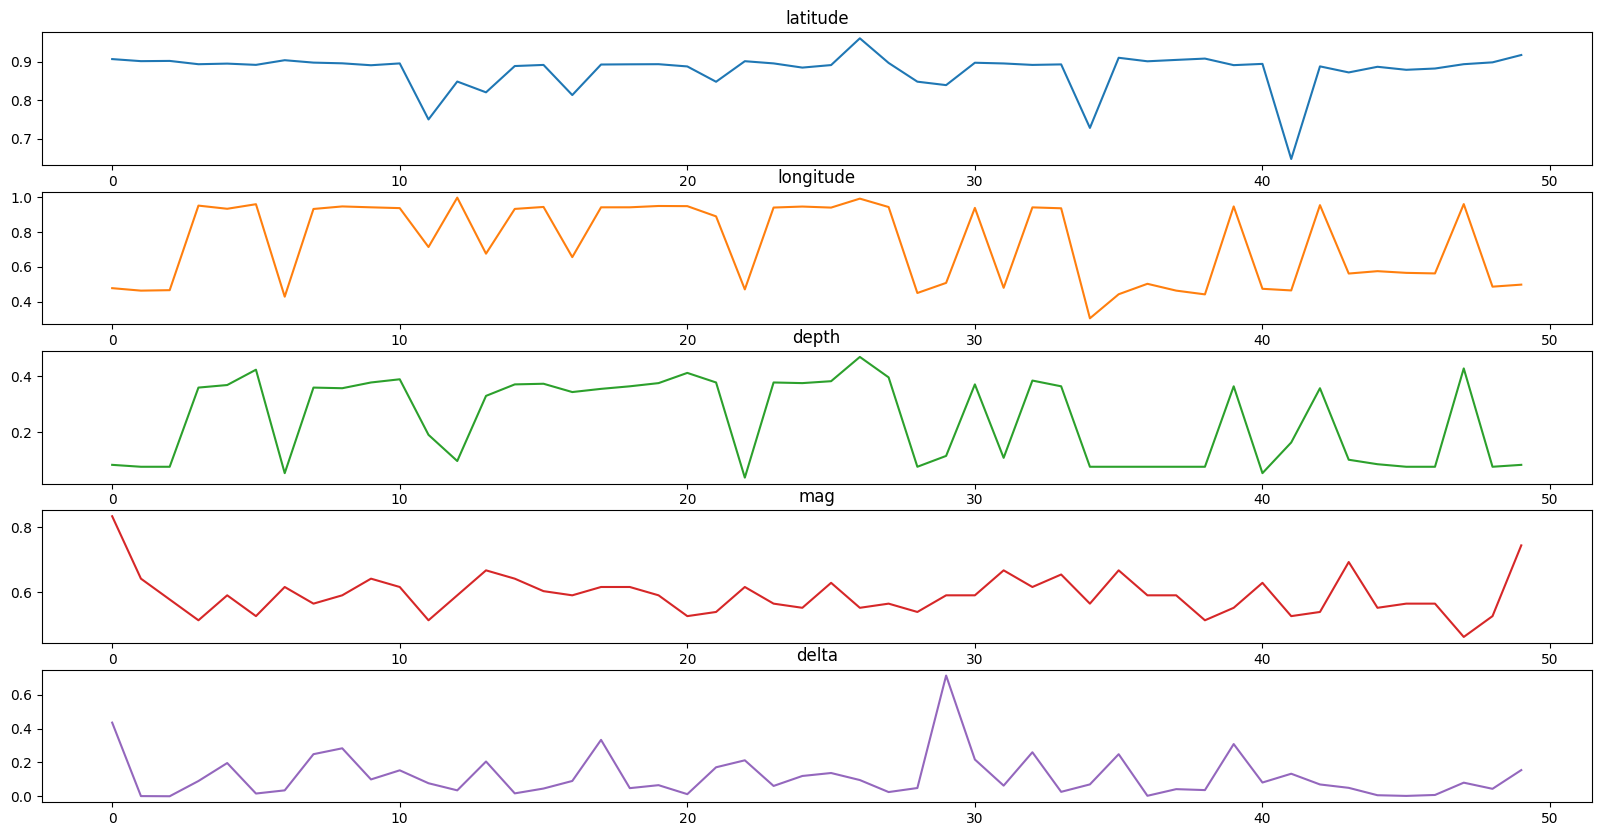

In [6]:
plot_timeseries(pd.DataFrame(X_train[1], columns=qdata.numeric_columns))

In [7]:
class ForecastModel(nn.Module):
    def __init__(self, feature_size: int, hidden_size: int, num_layers: int):
        """
        Call LSTM layers take a (seq_size, feature_size) tensor, and outputs a hidden_size tensor
        for batch processing batch_first is enabled so we would process (batch, seq_size, feature_size)
        """
        super().__init__()
        # num_layers is the number of LSTM layers stacked on top of each other
        # this would preferably be equivalent to the number of lookbacks
        self.lstm = nn.LSTM(feature_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.bn(out)
        return self.linear(out)

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available()

True

In [9]:

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
model = ForecastModel(features, hidden_size, num_layers).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()


In [10]:
n_epochs = 150
epoch_losses = []
epoch_val_losses = []
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch.to(device)).detach().cpu()
            val_loss += loss_fn(y_pred, y_batch).item()
    
    epoch_losses.append(epoch_loss)
    epoch_val_losses.append(val_loss)
    print("Epoch %d: loss %.4f val_loss: %.4f" % (epoch, epoch_loss, val_loss))

Epoch 0: loss 36.5620 val_loss: 0.4872
Epoch 1: loss 4.0544 val_loss: 0.4222
Epoch 2: loss 2.7394 val_loss: 0.4284
Epoch 3: loss 2.7023 val_loss: 0.4314
Epoch 4: loss 2.7004 val_loss: 0.4347
Epoch 5: loss 2.7195 val_loss: 0.4357
Epoch 6: loss 2.7080 val_loss: 0.4325
Epoch 7: loss 2.7248 val_loss: 0.4324
Epoch 8: loss 2.7182 val_loss: 0.4317
Epoch 9: loss 2.7398 val_loss: 0.4408
Epoch 10: loss 2.7364 val_loss: 0.4409
Epoch 11: loss 2.7290 val_loss: 0.4447
Epoch 12: loss 2.7491 val_loss: 0.4495
Epoch 13: loss 2.7737 val_loss: 0.4375
Epoch 14: loss 2.7441 val_loss: 0.4445
Epoch 15: loss 2.7276 val_loss: 0.4331
Epoch 16: loss 2.7382 val_loss: 0.4385
Epoch 17: loss 2.7350 val_loss: 0.4540
Epoch 18: loss 2.7327 val_loss: 0.4350
Epoch 19: loss 2.7262 val_loss: 0.4402
Epoch 20: loss 2.7134 val_loss: 0.4421
Epoch 21: loss 2.7299 val_loss: 0.4423
Epoch 22: loss 2.7305 val_loss: 0.4434
Epoch 23: loss 2.7365 val_loss: 0.4595
Epoch 24: loss 2.7243 val_loss: 0.4409
Epoch 25: loss 2.7154 val_loss: 0.

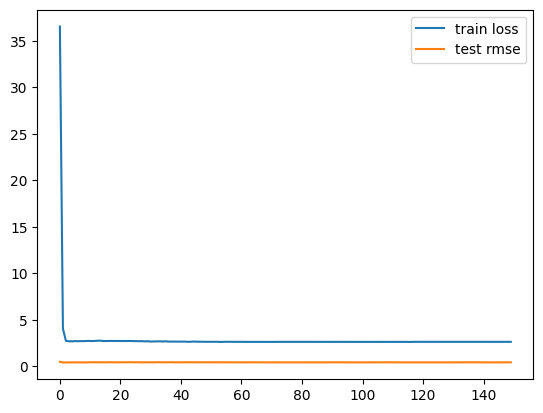

In [11]:
plt.plot(epoch_losses, label='train loss')
plt.plot(epoch_val_losses, label='test rmse')
plt.legend()
plt.show()

(4860, 1) (4860, 1) (4860, 1)


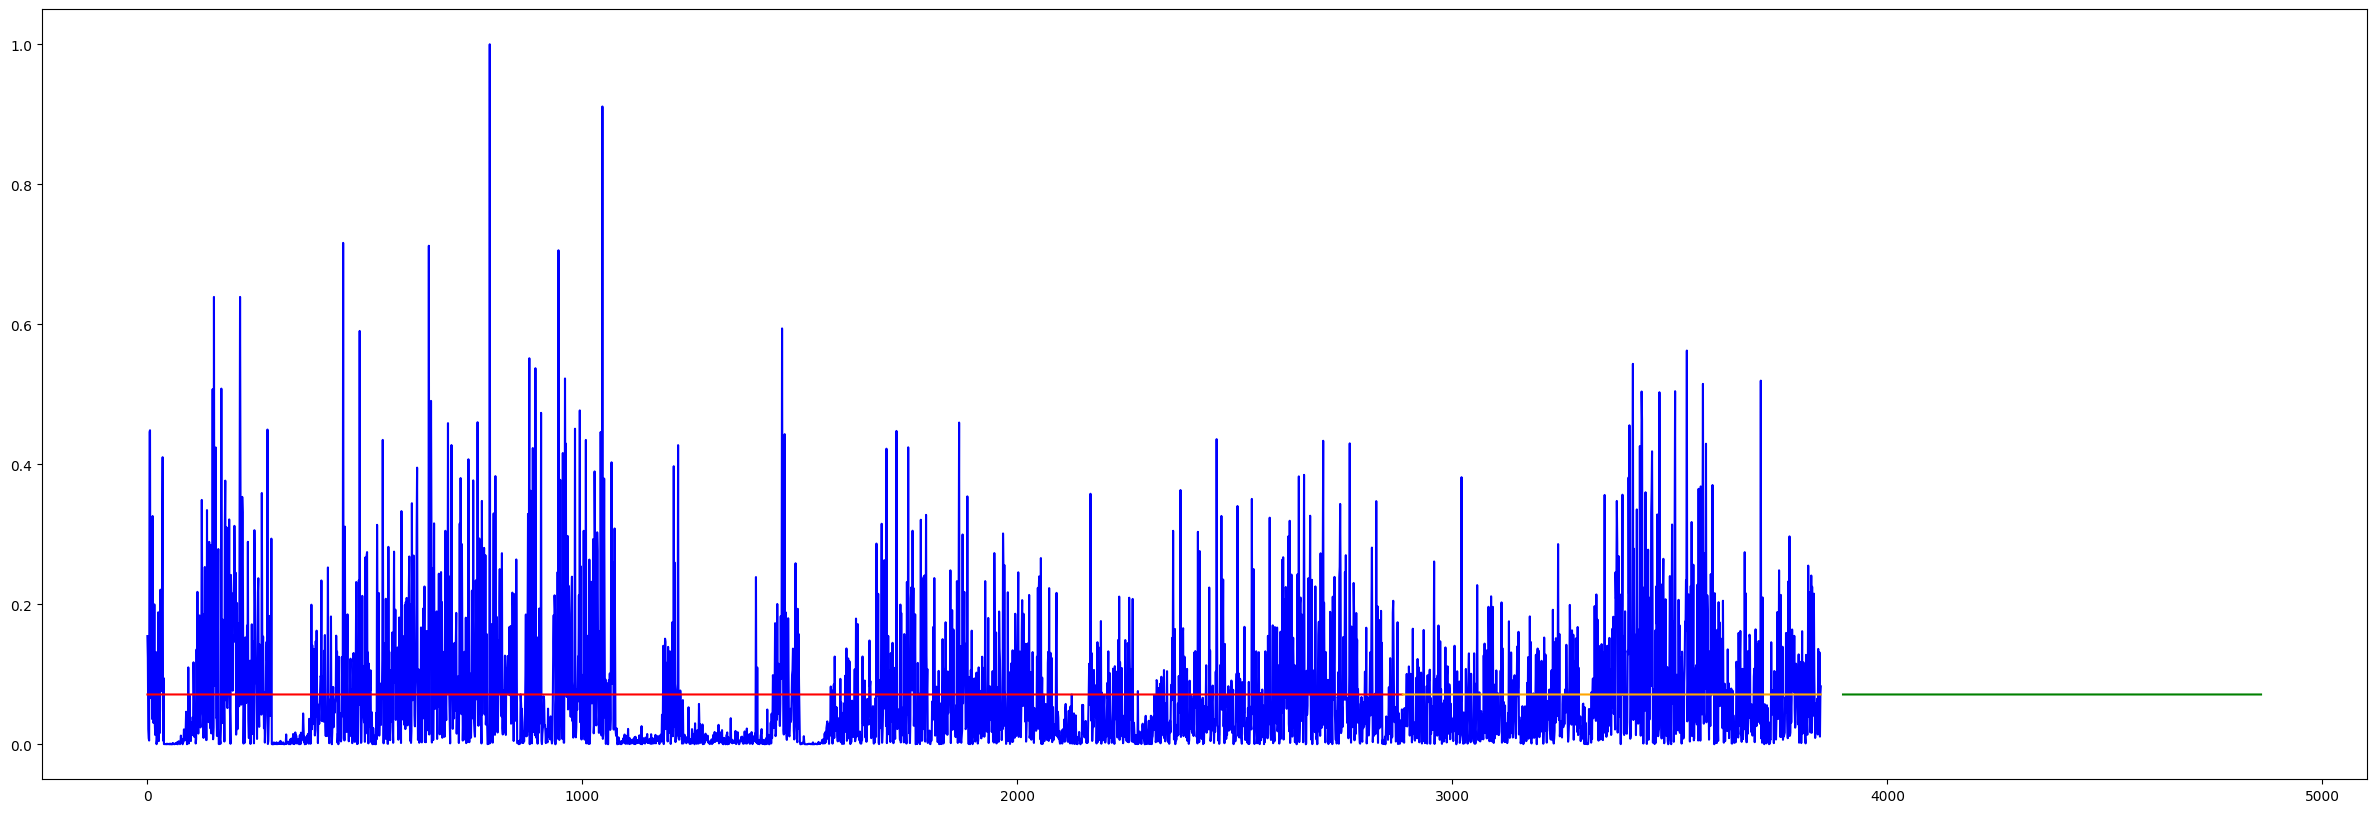

In [12]:
model.eval()
train_plot = np.ones((qdata.data.shape[0], 1)) * np.nan
val_plot = np.ones((qdata.data.shape[0], 1)) * np.nan
test_plot = np.ones((qdata.data.shape[0], 1)) * np.nan

print(train_plot.shape, val_plot.shape, test_plot.shape)
with torch.no_grad():
    # shift train predictions for plotting
    train_size = len(X_train)
    val_size = len(X_val)
    test_size = len(X_test)
    
    train_input = torch.Tensor(X_train).to(device)
    train_pred = model(train_input).detach().cpu()
    train_plot[:train_size] = train_pred
    
    val_input = torch.Tensor(X_val).to(device)
    val_pred = model(val_input).detach().cpu()
    val_plot[train_size:train_size+val_size] = val_pred
    
    # shift test predictions for plotting
    test_input = torch.Tensor(X_test).to(device)
    test_pred = model(test_input).detach().cpu()
    test_plot[train_size+val_size+lookback:] = test_pred

plt.gcf().set_size_inches(30, 10)
plt.plot(np.concatenate([y_train,y_test]), c='b')
plt.plot(train_plot, c='r')
plt.plot(val_plot, c='orange')
plt.plot(test_plot, c='g')


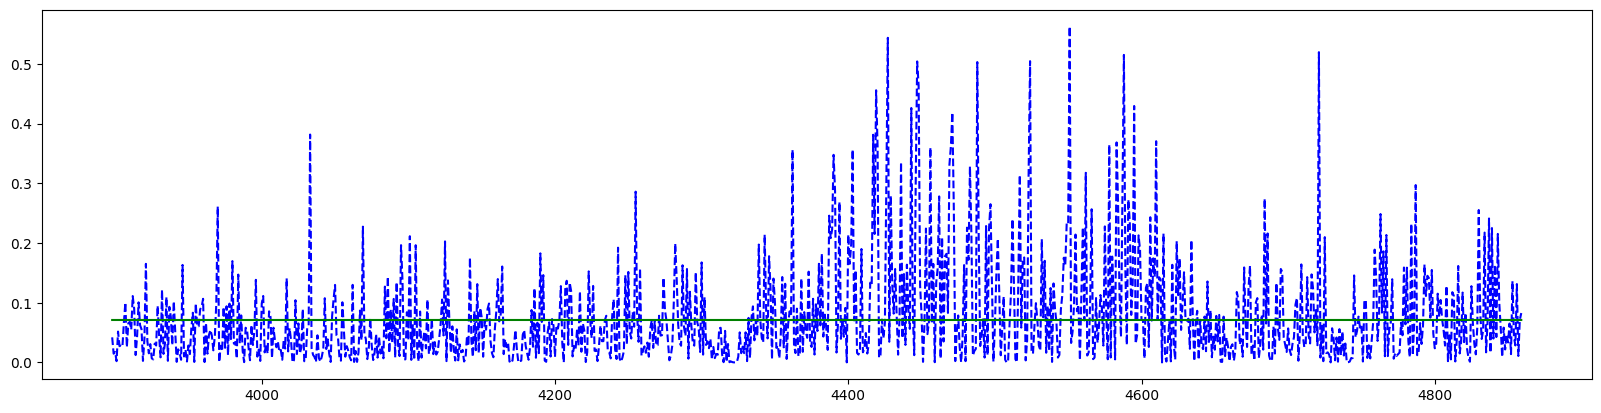

In [13]:
test_plot2 = np.ones((qdata.data.shape[0], 1)) * np.nan
test_plot2[train_size+val_size+lookback:] = y_test

plt.plot(test_plot2, c='b', linestyle='--')
plt.plot(test_plot, c='g')
plt.gcf().set_figwidth(20)
plt.show()

Hstack (2886, 2)


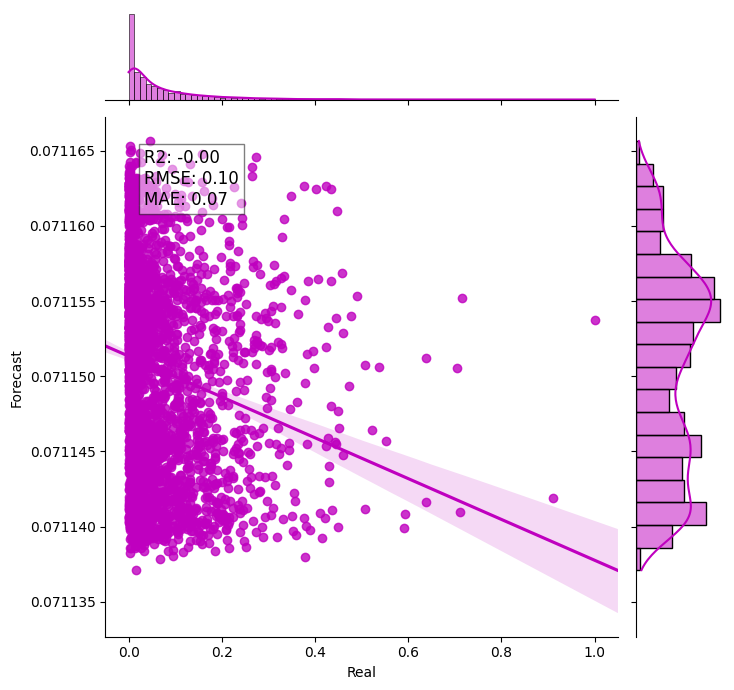

In [14]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
original, forecast = y_train.numpy(), train_pred.numpy()
hstack = np.hstack((original, forecast))
print("Hstack", hstack.shape)

g = sns.jointplot(
    x="Real",
    y="Forecast",
    data=pd.DataFrame(hstack, columns=["Real", "Forecast"]),
    kind="reg",
    truncate=False,
    color="m",
    height=7,
)

test_loss = mean_squared_error(original, forecast)
test_mae = mean_absolute_error(original, forecast)
test_r2 = r2_score(original, forecast)
test_rmse = np.sqrt(test_loss)

# Add metrics to the plot
plt.figtext(
    0.15,
    0.70,
    f"R2: {test_r2:.2f}\nRMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}",
    bbox=dict(facecolor="white", alpha=0.5),
    fontsize=12,
)
plt.show()

Hstack (962, 2)


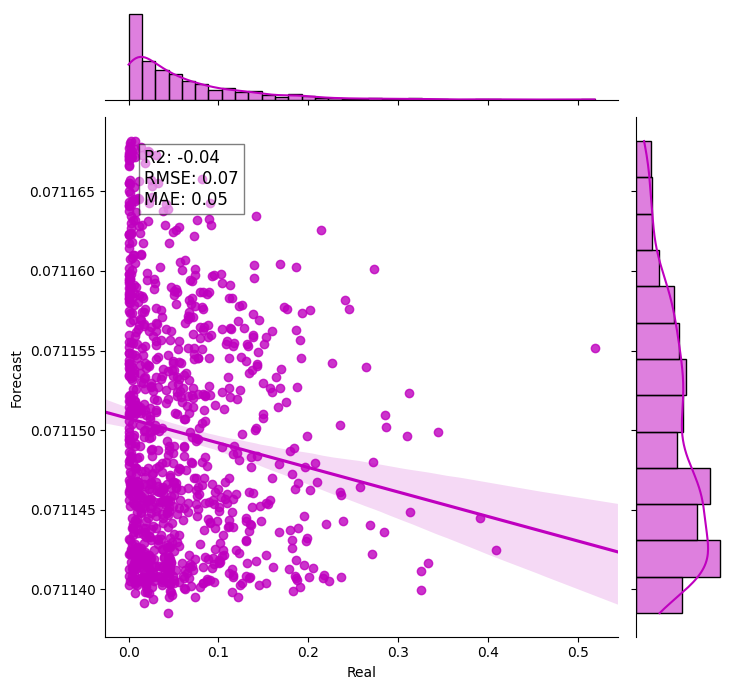

In [15]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
original, forecast = y_val.numpy(), val_pred.numpy()
hstack = np.hstack((original, forecast))
print("Hstack", hstack.shape)

g = sns.jointplot(
    x="Real",
    y="Forecast",
    data=pd.DataFrame(hstack, columns=["Real", "Forecast"]),
    kind="reg",
    truncate=False,
    color="m",
    height=7,
)

test_loss = mean_squared_error(original, forecast)
test_mae = mean_absolute_error(original, forecast)
test_r2 = r2_score(original, forecast)
test_rmse = np.sqrt(test_loss)

# Add metrics to the plot
plt.figtext(
    0.15,
    0.70,
    f"R2: {test_r2:.2f}\nRMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}",
    bbox=dict(facecolor="white", alpha=0.5),
    fontsize=12,
)
plt.show()

Hstack (962, 2)


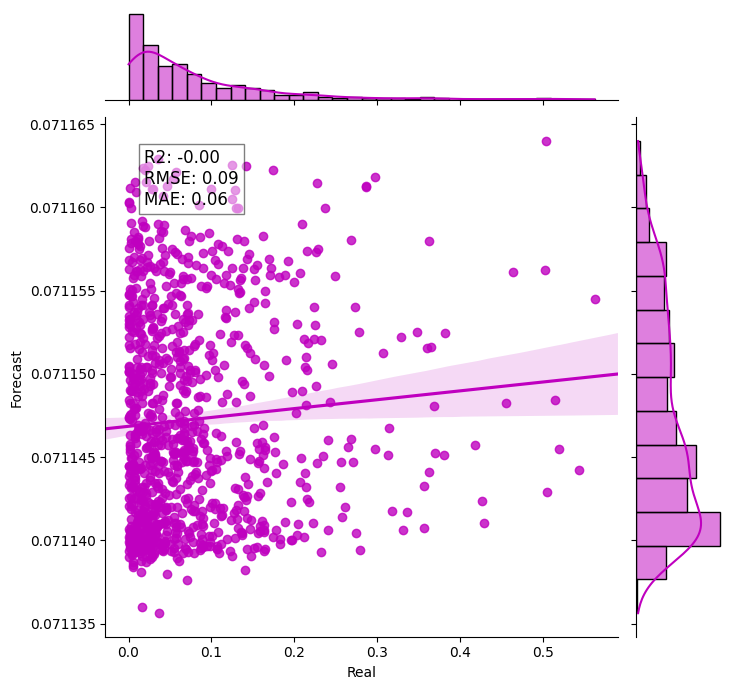

In [16]:
original, forecast = y_test.numpy(), test_pred.numpy()
hstack = np.hstack((original, forecast))
print("Hstack", hstack.shape)

g = sns.jointplot(
    x="Real",
    y="Forecast",
    data=pd.DataFrame(hstack, columns=["Real", "Forecast"]),
    kind="reg",
    truncate=False,
    color="m",
    height=7,
)

test_loss = mean_squared_error(original, forecast)
test_mae = mean_absolute_error(original, forecast)
test_r2 = r2_score(original, forecast)
test_rmse = np.sqrt(test_loss)

# Add metrics to the plot
plt.figtext(
    0.15,
    0.70,
    f"R2: {test_r2:.2f}\nRMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}",
    bbox=dict(facecolor="white", alpha=0.5),
    fontsize=12,
)
plt.show()